# KTR Orbit Model for Media Mix Models: A controlled simulation example

[Bayesian Time Varying Coefficient Model with Applications to Marketing Mix Modeling](https://arxiv.org/abs/2106.03322)

## Prepare Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from orbit.models import KTR
from scipy.ndimage import gaussian_filter
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "svg"

In [2]:
# let us get orbit version
! pip list | grep -i "orbit"

orbit-ml                     1.1.1.dev0 /Users/juanitorduz/.local/share/virtualenvs/rd-B0ctCRMH/src/orbit-ml


## Generate Sample Data

We are going to generate a sample data set. The main idea is to generate a time series $y$ which will represent target variable, lets say *sales*. This time series will consist of various components: a trend, a seasonal component, an external regressor and some gaussian noise. We will describe the components in more detail below. For now, let us tart by generating the data range: $3$ years of weekly data.

In [3]:
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
)

data_df = data_df.assign(
    year = lambda x: x["date"].dt.year,
    month = lambda x: x["date"].dt.month,
    dayofyear = lambda x: x["date"].dt.dayofyear,
)

n = data_df.shape[0]

### Media Cost Features

- **Generate Media Cost Feature**

Let us start by defining the external regressor: a media cost feature. This variable will play the role of sales driver for our target variable. In practice, the marketing manager will have control over this variable. In this example we use a uniform distribution to simulate it.

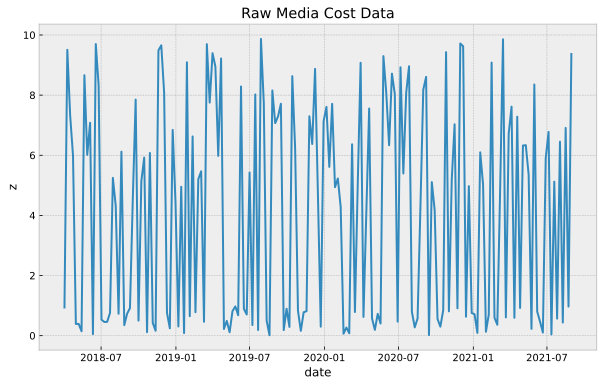

In [4]:
SEED = 42
np.random.seed(SEED)

# sample from a uniform distribution on [0, 1] and cutand some threshold (0.4)
z = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z"] = 10 * np.where( z > 0.4, z, z/4)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="z", data=data_df, ax=ax)
ax.set(title="Raw Media Cost Data");

- *Adstock Transformation*

Next we apply an [adstock transformation](https://en.wikipedia.org/wiki/Advertising_adstock) to the media cost feature. This transformation aims to model the carry over effect of media spend. See [Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects." (2017)](https://research.google/pubs/pub46001/) for more details.

**Remark:** In practice we would like to *learn* the adstock curve from the data. This can be done with [PyMC](https://docs.pymc.io/en/v3/) as illustrated in the blog post [Bayesian Marketing Mix Modeling in Python via PyMC3](https://towardsdatascience.com/bayesian-marketing-mix-modeling-in-python-via-pymc3-7b2071f6001a). This approach was also used in HelloFresh's Media Mix Model, as presented in the following resources:
- Article: [Bayesian Media Mix Modeling using PyMC3, for Fun and Profit](https://engineering.hellofresh.com/bayesian-media-mix-modeling-using-pymc3-for-fun-and-profit-2bd4667504e6) 
- Video: [A Bayesian Approach to Media Mix Modeling by Michael Johns & Zhenyu Wang](https://www.youtube.com/watch?v=UznM_-_760Y)
- Articles: [Bayesian Media Mix Modeling for Marketing Optimization](https://www.pymc-labs.io/blog-posts/bayesian-media-mix-modeling-for-marketing-optimization/) and [Improving the Speed and Accuracy of Bayesian Media Mix Models](https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/) by [PyMC Labs](https://www.pymc-labs.io/)

For this specific example we are going to assume a certain heuristic for the adstock curve, and hence it will not be part of the model. We are going to apply a *geometric adstock transformation*, which is defined by the following transformer:

In [5]:
class GeometricAdstockTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, alpha: float = 0.0, l: int = 12):
        self.alpha = alpha
        self.l = l

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        if isinstance(x, pd.DataFrame):
            x = x.to_numpy()
        cycles = [
            np.append(
                arr=np.zeros(shape=x.shape)[:i],
                values=x[: x.shape[0] - i],
                axis=0
            ) 
            for i in range(self.l)
        ]
        x_cycle = np.stack(cycles, axis=0)
        w = np.array([np.power(self.alpha, i) for i in range(self.l)])
        return np.tensordot(a=w, b=x_cycle, axes=1)

Next, lets apply the adstock transformation to the media cost feature.

In [6]:
# the effect carryover factor is 1/2 (usual assumption)
alpha = 1/2
# The carryover period is 12 weeks, which is also quite reasonable.
l = 12 

geometric_adstock_transformer = GeometricAdstockTransformer(alpha=alpha, l=l)

data_df["z_adstock"] = geometric_adstock_transformer.fit_transform(data_df["z"])

Let us plot the transformed data:

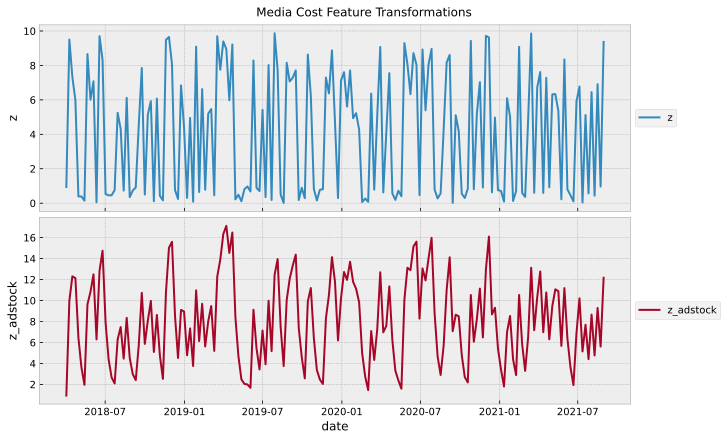

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, layout="constrained")

features = ["z", "z_adstock"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

- **Saturation Transformation:**

Now we apply a saturation transformation to the media cost feature, which should capture the non-linear effect of media in sales (otherwise the marketing manager would just spending more and more to increase sales, but experience and intuition shows the relation is non-linear and eventually saturates). There are many possible parametrizations for such a transformation, but we will use the following one:

$$
x\longmapsto \frac{1 - e^{-\mu x}}{1 + e^{-\mu x}}
$$

Let us implement the corresponding transformer:

In [8]:
class LogisticSaturationTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, mu: float = 0.5):
        self.mu = mu

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return (1 - np.exp(-self.mu * x)) / (1 + np.exp(-self.mu * x))

We can now apply the saturation transformation to the (adstock) media cost feature.

In [9]:
mu = 1.5e-1

logistic_saturation_transformer = LogisticSaturationTransformer(mu=mu)

data_df["z_adstock_saturated"] = logistic_saturation_transformer.fit_transform(data_df["z_adstock"])

We will not use `z_adstock_saturated` in our model and we would like to recover the saturation effect. Let us plot the saturation curve:

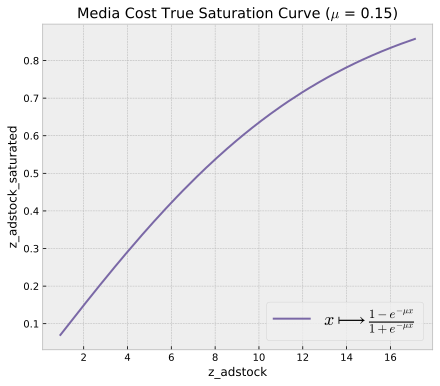

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))

latex_function = r"$x\longmapsto \frac{1 - e^{-\mu x}}{1 + e^{-\mu x}}$"
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label=latex_function,
    data=data_df,
    ax=ax
)
ax.legend(loc="lower right", prop={"size": 18})
ax.set(title=f"Media Cost True Saturation Curve ($\mu$ = {mu})");

Note that the saturation curve is almost linear for values `z_adstock` < $6$. After this point the first derivative starts to decrease.

**Remark:** It is clear that the adstock and saturation transformations do not commute (i.e. the order matters). Which one to apply first? Following [Jin, Yuxue, et al. "Bayesian methods for media mix modeling with carryover and shape effects." (2017)](https://research.google/pubs/pub46001/) , section 2.3:
> *We could first apply the adstock transformation to the time series of media spend, and then apply
the shape transformation. An alternative way would be to reverse the order. If media spend in
each time period is relatively small compared to the cumulative spend across multiple time periods,
the shape effect in each time period is less obvious compared to that of cumulative media spend.
In this case, we would prefer to apply the shape transformation after the adstock transformation.
However, if the media spend is heavily concentrated in some single time periods with an on-and-off
pattern, the latter choice might be preferable.*

Let us now plot all the transformations:

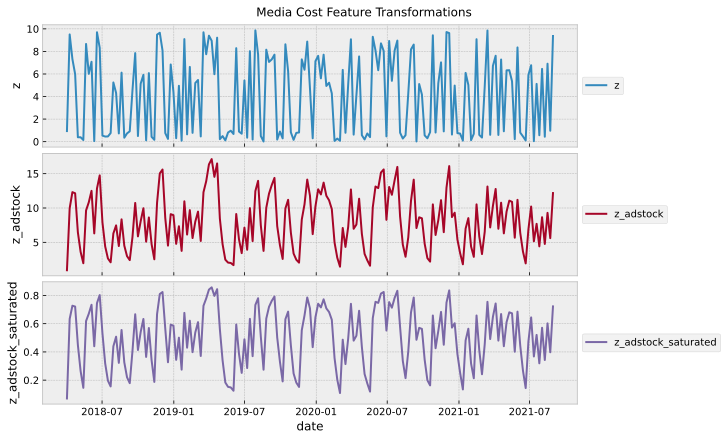

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")

features = ["z", "z_adstock", "z_adstock_saturated"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

- **Diminishing Returns Over Time**

Finally, we want to assume that the overall media efficiency decreases over time. We can do this by multiplying  `z_adstock_saturated` with a decreasing function. We would expect to recover the decreasing effect with Orbit's KTR model. Let us consider a rational function:

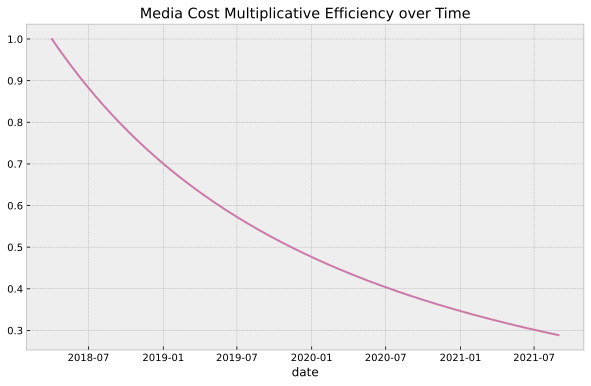

In [12]:
data_df["beta"] =  (np.arange(start=0.0, stop=1.0, step=1/n) + 1) ** (-1.8)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="beta", color="C5", data=data_df, ax=ax)
ax.set(title="Media Cost Multiplicative Efficiency over Time", ylabel=None);

Next, we compute the product of `beta` and `z_adstock_saturated`:

In [13]:
data_df["z_effect"] = data_df["beta"] * data_df["z_adstock_saturated"]

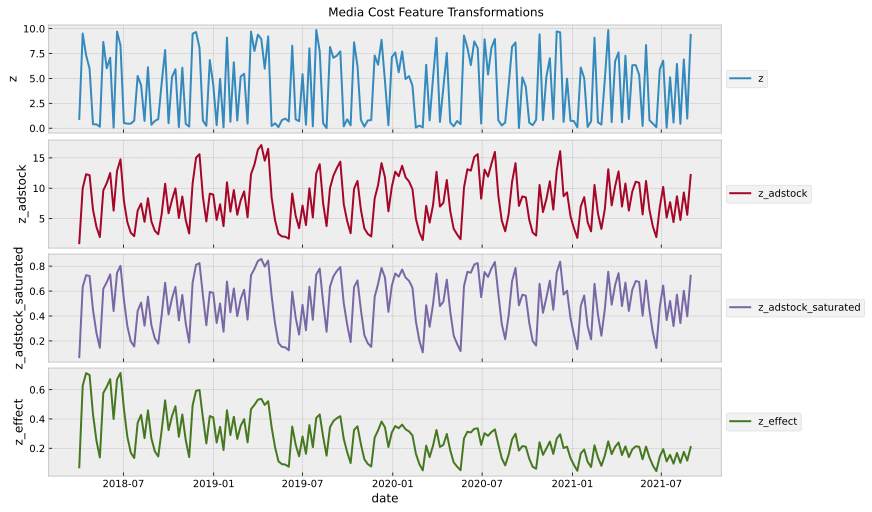

In [14]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=False,
    layout="constrained"
)

features = ["z", "z_adstock", "z_adstock_saturated", "z_effect"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

Recall that for the model we will assume we have `z_adstock` and we would like to recover `z_effect`. Let us now plot the `effect ratio` defined by `z_effect` / `z_adstock`.  

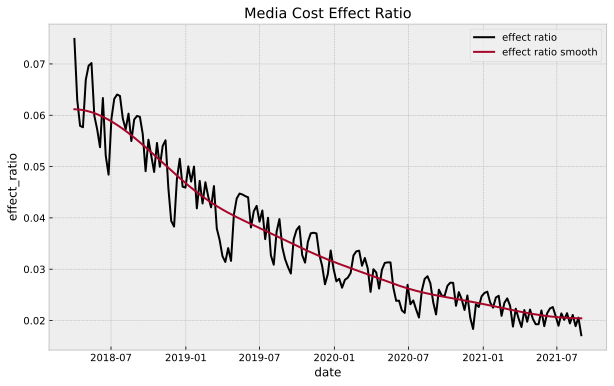

In [15]:
data_df.eval(expr="effect_ratio = z_effect / z_adstock", inplace=True)

data_df["effect_ratio_smooth"] = gaussian_filter(input=data_df["effect_ratio"], sigma=12)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="effect_ratio", color="black", label="effect ratio", data=data_df, ax=ax)
sns.lineplot(x="date", y="effect_ratio_smooth", color="C1", label="effect ratio smooth", data=data_df, ax=ax)
ax.set(title="Media Cost Effect Ratio");

**Remark:** Note that we applied the saturation and diminishing returns transformations independently. We could have done it differently by simply making $\mu=\mu(t)$ time dependent in the `LogisticSaturationTransformer`. For example,

```python
mu = np.linspace(start=0.05, stop=0.1, num=n)[::-1] ** (1.25)
```

### Trend and Seasonality

In [16]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10)**(1/4) - 1 

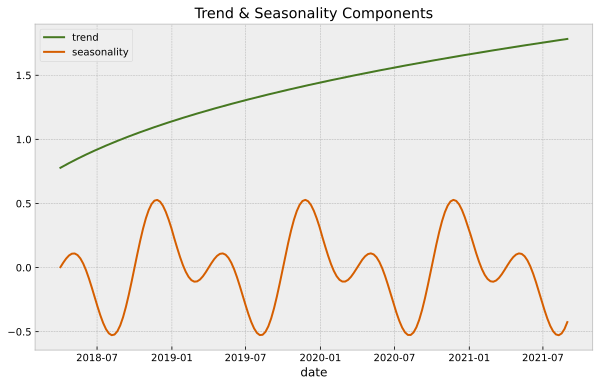

In [17]:
data_df["cs"] = - np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.5) 
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.5)
data_df["s"] = 0.3 * (data_df["cs"] + data_df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date", y="trend", color="C3", label="trend", data=data_df, ax=ax)
sns.lineplot(x="date", y="s", color="C4", label="seasonality", data=data_df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel="");

### Target Variable: Sales

In [18]:
np.random.seed(SEED)

data_df["intercept"] = 3.0

data_df["epsilon"] = np.random.normal(loc=0.0, scale=5e-2, size=n)

In [19]:
data_df.eval(expr="y = intercept + trend + s + z_effect + epsilon", inplace=True)

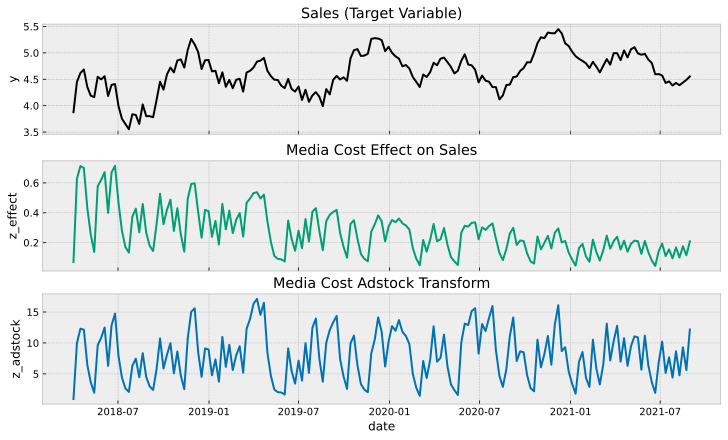

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=axes[0])
axes[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C7", data=data_df, ax=axes[1])
axes[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z_adstock", color="C9", data=data_df, ax=axes[2])
axes[2].set(title="Media Cost Adstock Transform");

<AxesSubplot:xlabel='date', ylabel='effect_ratio'>

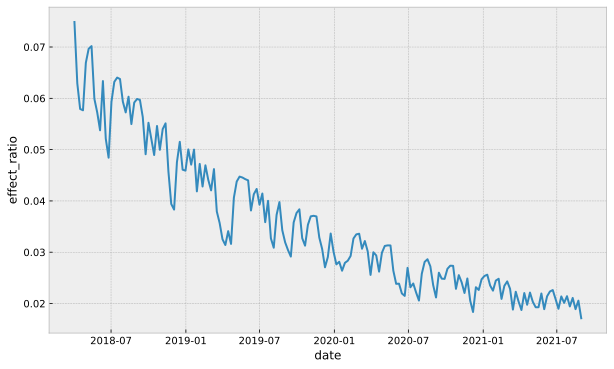

In [21]:
data_df.eval(expr="effect_ratio = z_effect / z_adstock", inplace=True)

fig, ax = plt.subplots()

sns.lineplot(x="date", y="effect_ratio", data=data_df, ax=ax)

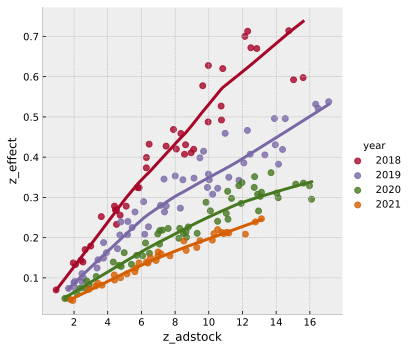

In [22]:
sns.lmplot(
    x="z_adstock",
    y="z_effect",
    hue="year",
    palette=["C1", "C2", "C3", "C4"],
    lowess=True,
    data=data_df.assign(year = lambda x: x["date"].dt.year.astype(str)),
)

## Model

In [23]:
date_col = "date"
response_col = "y"
regressor_col = ["z_adstock"]

p = len(regressor_col)

ktr = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    prediction_percentiles=[2.5, 97.5],
    seasonality=[52.25],
    regressor_sign=["+"]*p,
    seed=42,
    estimator='pyro-svi',
)

In [24]:
ktr.fit(df=data_df)

INFO:orbit:Optimizing(PyStan) with algorithm:LBFGS .
INFO:orbit:Using SVI(Pyro) with steps:301 , samples:100 , learning rate:0.1, learning_rate_total_decay:1.0 and particles:100 .
INFO:root:Guessed max_plate_nesting = 1
INFO:orbit:step    0 loss = 6404.2, scale = 0.10141
INFO:orbit:step  100 loss = -165.87, scale = 0.19816
INFO:orbit:step  200 loss = -181.16, scale = 0.18474
INFO:orbit:step  300 loss = -193.39, scale = 0.16999


In [25]:
pred_df = ktr.predict(df=data_df, decompose=True)

pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    179 non-null    datetime64[ns]
 1   prediction_2.5          179 non-null    float64       
 2   prediction              179 non-null    float64       
 3   prediction_97.5         179 non-null    float64       
 4   trend_2.5               179 non-null    float64       
 5   trend                   179 non-null    float64       
 6   trend_97.5              179 non-null    float64       
 7   regression_2.5          179 non-null    float64       
 8   regression              179 non-null    float64       
 9   regression_97.5         179 non-null    float64       
 10  seasonality_52.25_2.5   179 non-null    float64       
 11  seasonality_52.25       179 non-null    float64       
 12  seasonality_52.25_97.5  179 non-null    float64   

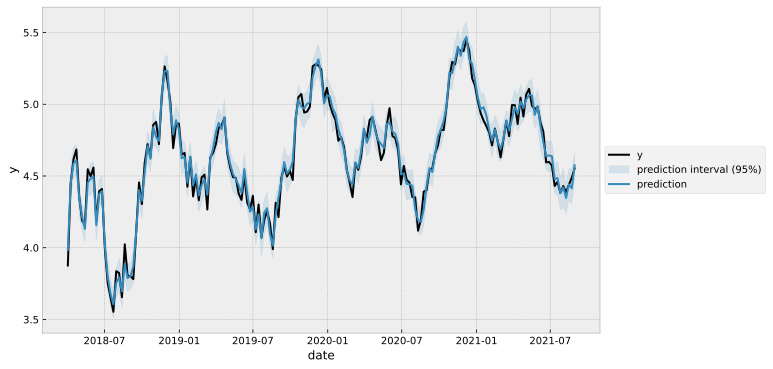

In [26]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", label="y", data=data_df, ax=ax)
ax.fill_between(
    x=pred_df["date"],
    y1=pred_df["prediction_2.5"],
    y2=pred_df["prediction_97.5"],
    color="C0",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(x="date", y="prediction", color="C0", label="prediction", data=pred_df, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


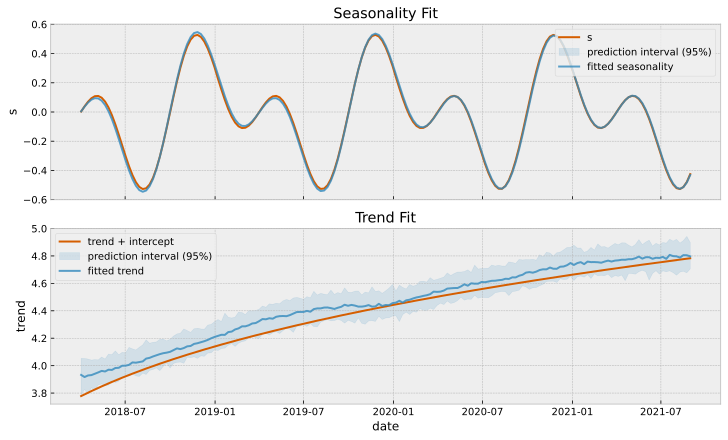

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, layout="constrained")

sns.lineplot(x="date",
    y="s",
    color="C4",
    label="s",
    data=data_df,
    ax=ax[0]
)
ax[0].fill_between(
    x=pred_df["date"],
    y1=pred_df["seasonality_52.25_2.5"],
    y2=pred_df["seasonality_52.25_97.5"],
    color="C10",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(
    x="date",
    y="seasonality_52.25",
    alpha=0.8,
    color="C10",
    label="fitted seasonality",
    data=pred_df,
    ax=ax[0]
)
ax[0].set(title="Seasonality Fit")

sns.lineplot(
    x=data_df["date"],
    y=data_df["trend"] + data_df["intercept"],
    color="C4",
    label="trend + intercept",
    ax=ax[1]
)
ax[1].fill_between(
    x=pred_df["date"],
    y1=pred_df["trend_2.5"],
    y2=pred_df["trend_97.5"],
    color="C10",
    alpha=0.15,
    label="prediction interval (95%)"
)
sns.lineplot(
    x="date",
    y="trend",
    alpha=0.8,
    color="C10",
    label="fitted trend",
    data=pred_df,
    ax=ax[1]
)
ax[1].set(title="Trend Fit");

In [28]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

In [29]:
for df in [coef_mid, coef_lower, coef_upper ]:
    df["z_effect_pred"] = df["z_adstock"] * data_df["z_adstock"]
    df["year"] = df["date"].dt.year

<AxesSubplot:xlabel='date', ylabel='z_effect_pred'>

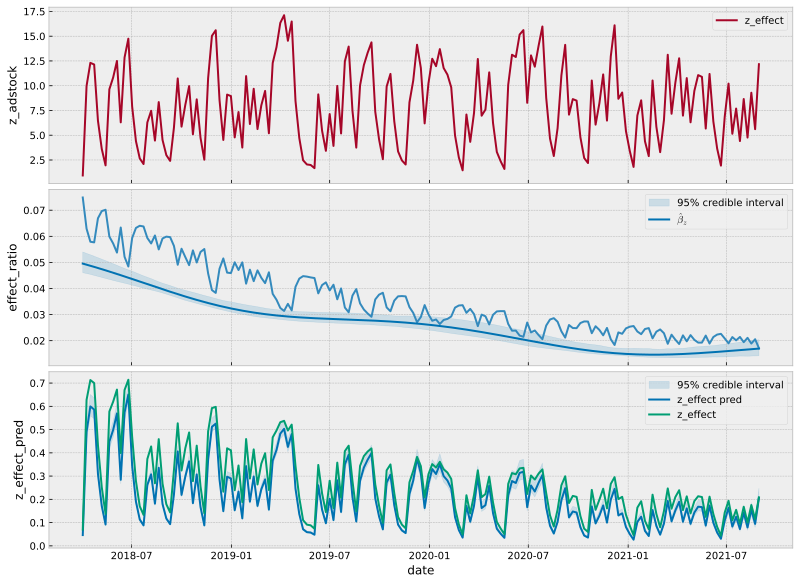

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(11, 8), sharex=True, sharey=False, layout="constrained")

sns.lineplot(x="date",
    y="z_adstock",
    color="C1",
    label="z_effect",
    data=data_df,
    ax=ax[0]
)


sns.lineplot(x="date", y="effect_ratio", data=data_df, ax=ax[1])
ax[1].fill_between(
    x=coef_mid["date"],
    y1=coef_lower["z_adstock"],
    y2=coef_upper["z_adstock"],
    color="C9",
    label="95% credible interval",
    alpha=0.15
)
sns.lineplot(
    x="date",
    y="z_adstock",
    color="C9",
    label="$\hat{\\beta}_{z}$",
    data=coef_mid,
    ax=ax[1]
)

ax[2].fill_between(
    x=coef_mid["date"],
    y1=coef_lower["z_effect_pred"],
    y2=coef_upper["z_effect_pred"],
    color="C9",
    label="95% credible interval",
    alpha=0.15
)
sns.lineplot(x="date",
    y="z_effect_pred",
    color="C9",
    label="z_effect pred",
    data=coef_mid,
    ax=ax[2]
)
sns.lineplot(x="date",
    y="z_effect",
    color="C7",
    label="z_effect",
    data=data_df,
    ax=ax[2]
)

In [31]:
 #data_df["year"].map({2019: "C0", 2020: "C1", 2021: "C2"}).to_list()

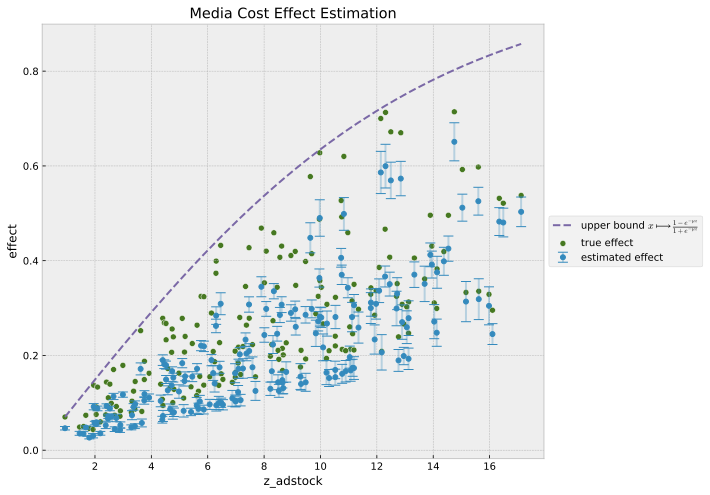

In [32]:
fig, ax = plt.subplots(figsize=(9, 8))

markers, caps, bars = ax.errorbar(
    x=data_df["z_adstock"], 
    y=coef_mid["z_effect_pred"], 
    yerr=(coef_upper["z_effect_pred"] - coef_lower["z_effect_pred"]) / 2,
    fmt='o',
    ms=5,
    capsize=5,
    label="estimated effect",
)
[bar.set_alpha(0.3) for bar in bars]


latex_function = r"$x\longmapsto \frac{1 - e^{-\mu z}}{1 + e^{-\mu z}}$"
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label="upper bound " + latex_function,
    linestyle="--",
    data=data_df,
    ax=ax
)
sns.scatterplot(
    x="z_adstock",
    y="z_effect",
    color="C3",
    label="true effect",
    data=data_df,
    ax=ax
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title="Media Cost Effect Estimation", ylabel="effect");

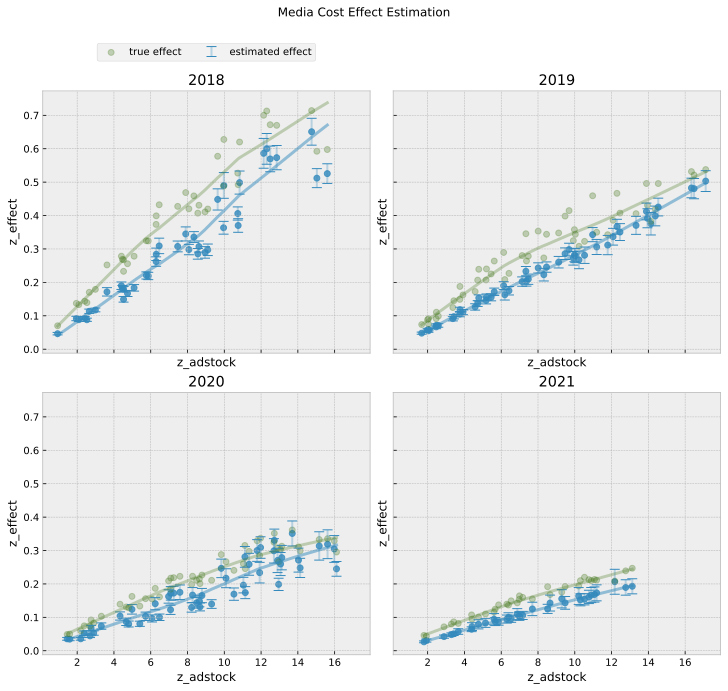

In [33]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(10, 9), 
    sharex=True,
    sharey=True,
    layout="constrained"
)

axes = axes.flatten()

for i, year in enumerate(data_df["year"].sort_values().unique()):
    
    ax = axes[i]
    mask = f"year == {year}"

    markers, caps, bars = ax.errorbar(
        x=data_df.query(mask)["z_adstock"], 
        y=coef_mid.query(mask)["z_effect_pred"], 
        yerr=(coef_upper.query(mask)["z_effect_pred"] - coef_lower.query(mask)["z_effect_pred"]) / 2,
        fmt='o',
        ms=0,
        capsize=5,
        label="estimated effect",
    )
    [bar.set_alpha(0.3) for bar in bars]

    sns.regplot(
        x=data_df.query(mask)["z_adstock"], 
        y=coef_mid.query(mask)["z_effect_pred"], 
        lowess=True,
        color="C0",
        line_kws={"alpha": 0.5},
        ax=ax
    )

    sns.regplot(
        x="z_adstock",
        y="z_effect",
        lowess=True,
        color="C3",
        label="true effect",
        data=data_df.query(mask),
        scatter_kws={"alpha": 0.3},
        line_kws={"alpha": 0.3},
        ax=ax
    )
    if i == 0:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
    else:
        ax.legend().remove()
    ax.set(title=f"{year}")
    
fig.suptitle("Media Cost Effect Estimation", y=1.05);